In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
import h5py

In [4]:
import seaborn as sns

In [5]:
from plotting_utils import *

In [8]:
root_path = '/media/akumar/54949792949774E8/Users/akumar/nse/uoicorr_analysis/notebooks/sfn'

In [9]:
lasso_engine = sqlalchemy.create_engine('sqlite:////%s/lasso.db' % root_path)
lasso_con = lasso_engine.connect()
mcp_engine = sqlalchemy.create_engine('sqlite:////%s/scad.db' % root_path)
mcp_con = mcp_engine.connect()
scad_engine = sqlalchemy.create_engine('sqlite:////%s/mcp.db' % root_path)
scad_con = scad_engine.connect()

uoi_engine = sqlalchemy.create_engine('sqlite:////%s/uoi.db' % root_path)
uoi_con = uoi_engine.connect()

en_engine = sqlalchemy.create_engine('sqlite:////%s/en.db' % root_path)
en_con = en_engine.connect()

In [10]:
# These guys are small enough to live in memory
lasso = pd.read_sql_table('pp_df', lasso_con)
mcp = pd.read_sql_table('pp_df', mcp_con)
scad = pd.read_sql_table('pp_df', scad_con)

uoi = pd.read_sql_table('pp_df', uoi_con)
en = pd.read_sql_table('pp_df', en_con)

In [11]:
sparsity = np.unique(uoi['sparsity'].values)

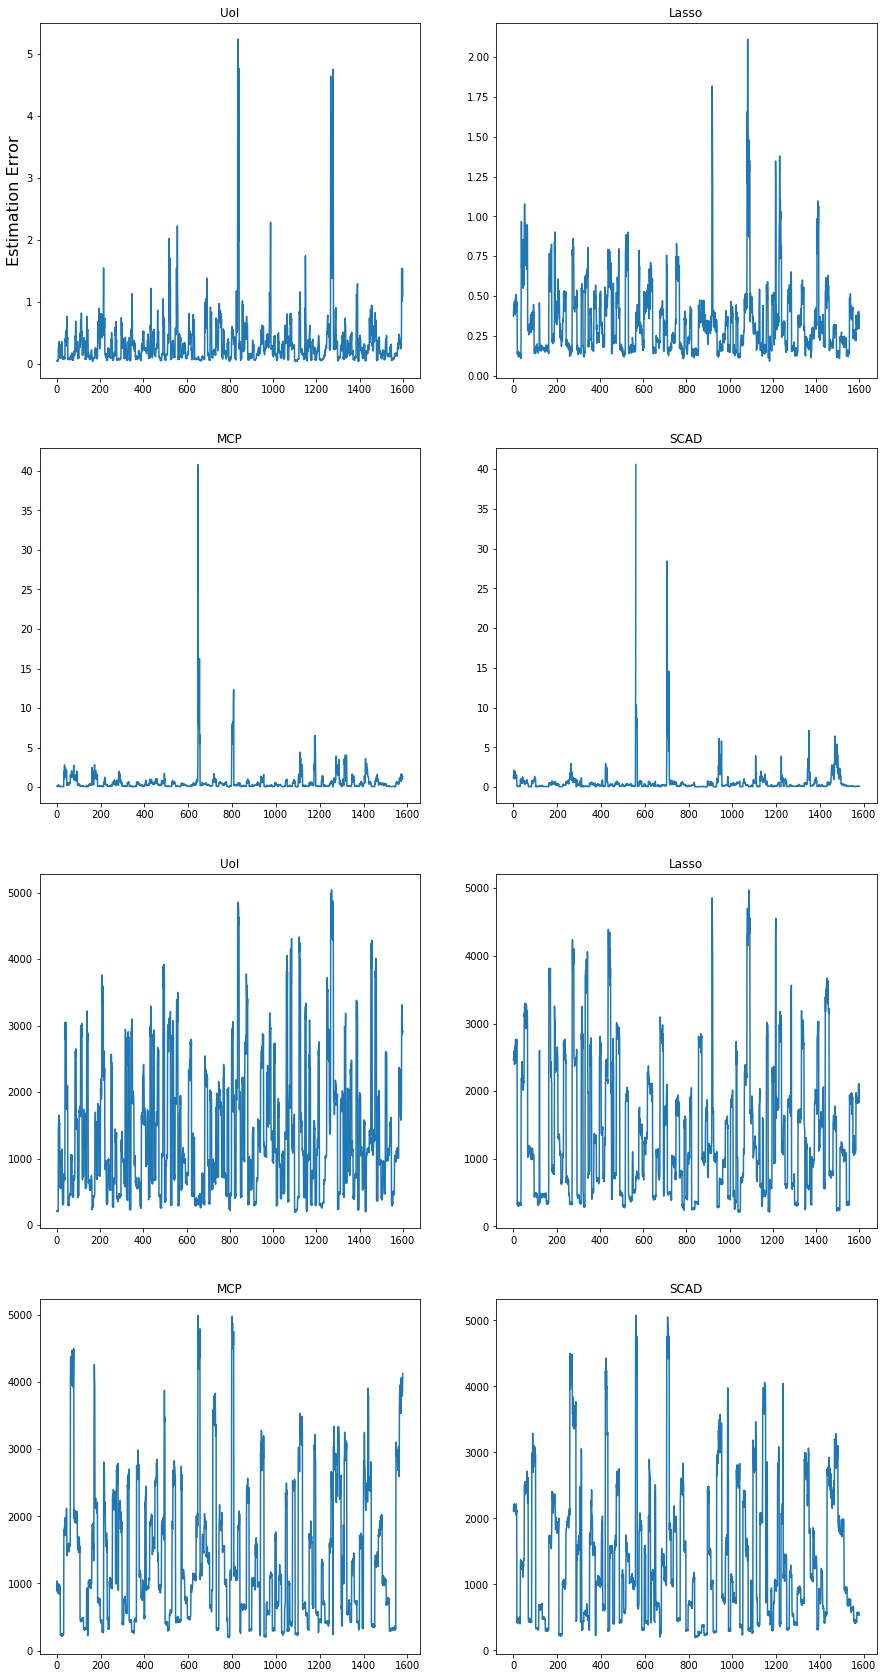

In [13]:
# Plot R2 and MSE when the supposed bias/variance is very high, esp. for SCAD/MCP

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
k = 5
kappa = np.unique(uoi['kappa'].values)
bw = np.inf
selection_method = 'BIC'

dframes = [uoi, lasso, mcp, scad]
#dframes = [uoi, en]
dframe_names = ['UoI', 'Lasso', 'MCP', 'SCAD']

fig, ax = plt.subplots(4, 2, figsize = (15, 30))

for i3, dframe in enumerate(dframes):

    a = ax[np.unravel_index(i3, (4, 2))]
    
    df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, sparsity = sparsity[5],
                          betawidth=bw, selection_method=selection_method)
    # Plot by unique_cov_params
    ucp, cidxs = unique_cov_params(df)
    values = df['ee'].values
    # order by average correlation
    avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
    cov_order = np.argsort(avg_cov)
    a.plot(values)
    a.set_title(dframe_names[i3])
    
ax[0, 0].set_ylabel('Estimation Error', fontsize = 16)

# Estimation variance 

# Select indices
for i3, dframe in enumerate(dframes):
    ui = np.unravel_index(i3, (4, 2))
    a = ax[2 + ui[0], ui[1]]
    
    df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, sparsity=sparsity[5], 
                          betawidth=bw, selection_method=selection_method)

    # Plot by unique_cov_params
    ucp, cidxs = unique_cov_params(df)
    values = df['MSE'].values
    # order by average correlation
    avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
    cov_order = np.argsort(avg_cov)
    a.plot(values)
    a.set_title(dframe_names[i3])
    
# ax[4, 0].set_ylabel('MSE', fontsize = 16)

In [ ]:
# These results look reasonable, in that there are particular failure modes, but otherwise things work out or 
# are at least comparable across algorithms

# Next, take a look at the SCAD bias/variance and see whether it matches up with our previous plots to debug
# whether there is something funky up with the way we are calculating things or whether the effect is real

# Do some interactive fits - does SCAD/MCP really demonstrate lower average bias than UoI. What about UoI 
# variance relative to Lasso?

# To potentially deal with this:
# Use some l2 regularization in the estimation module

In [6]:
# Load up the test fits
# scad_engine2 = sqlalchemy.create_engine('sqlite:////media/akumar/Data/nse/data/biastest/scad_pp.db')
# scad_con2 = scad_engine2.connect()

scad2 = pd.read_pickle('/media/akumar/Data/nse/data/biastest/scad_pp.dat')

In [7]:
# Load the coefficients directly
scadb = h5py.File('/media/akumar/Data/nse/data/biastest/scad_pp_beta.h5', 'r')

In [8]:
sparsity = np.unique(scad2['sparsity'].values)

In [9]:
scadb['beta_hat'].shape

(19200, 500)

In [10]:
def bias_from_file(beta_file, indices):
    
    bias = np.zeros(len(indices))
    
    first_hit = False
    
    for i, idx in enumerate(indices):
        bias[i] = np.linalg.norm(beta_file['beta_hat'][idx, :] - beta_file['beta'][idx, :])
        if bias[i] == 0 and not first_hit:
            print(i)
            first_hit = True
            
#     bias = np.array([np.linalg.norm(beta_file['beta_hat'][j, :] - beta_file['beta'][j, :])
#                      for j in indices])
    return bias        

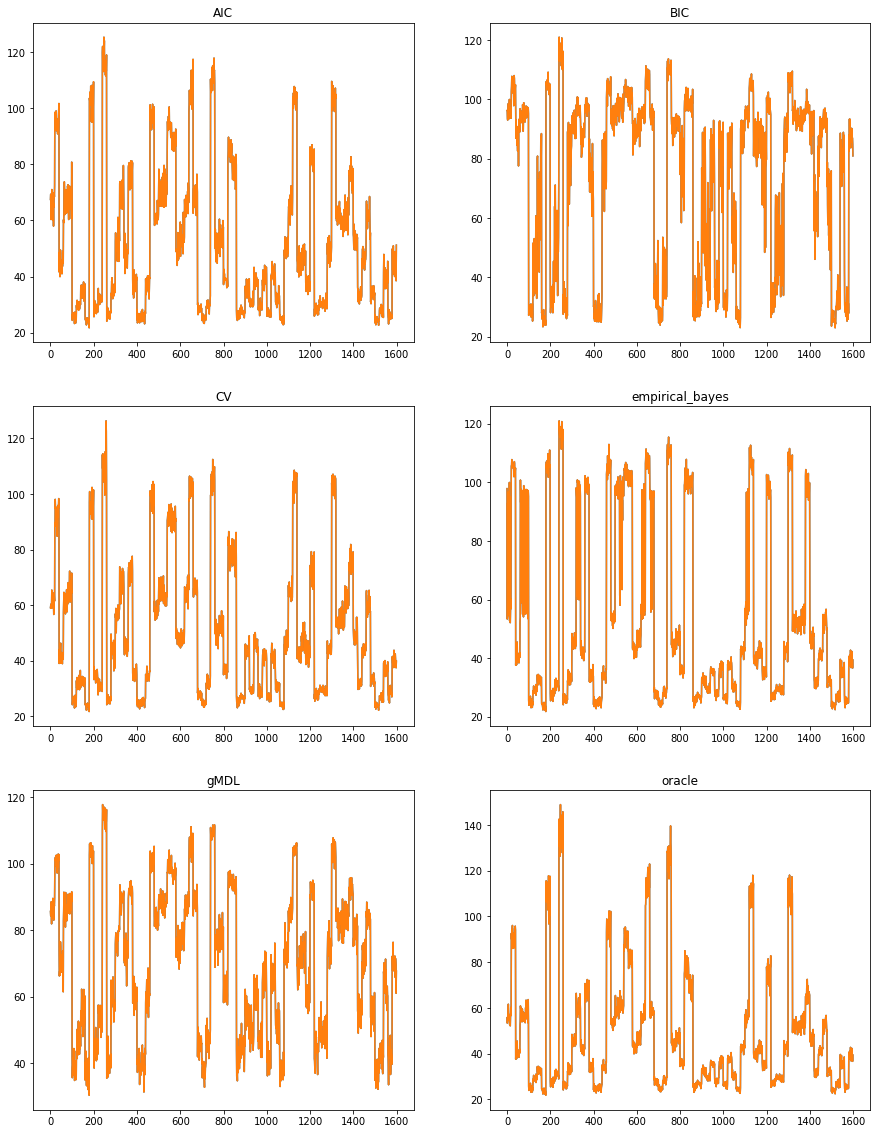

In [11]:
# Compare the bias to that we calculate from beta and beta_hat

fig, ax = plt.subplots(3, 2, figsize = (15, 20))

for i, sm in enumerate(np.unique(scad2['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]
    
    df = apply_df_filters(scad2, selection_method=sm, sparsity=sparsity[1])
    values = df['bias'].values
    
    # Calculate from the saved betas/beta_hats
    values2 = bias_from_file(scadb, list(df.index))
    # order by average correlation
    a.plot(values)
    a.plot(values2)
    a.set_title(sm)

In [ ]:
# Next steps: Compare Lasso and UoI --> Do an additional, small scale test to determine whether or not
# the increasing the number of estimation bootstraps or adding some L2 penalty can be helpful.